### Training of modified U-Net for Optic Disc on DRISHTI-GS database (cross-validation fold #0).

512 px cropped by Optic Disc area and resized to 128 px images were used.

You can either train your model or upload a pre-trained one from:
*../models_weights/02.03,13:57,OD Cup, U-Net light on DRISHTI-GS 512 px cropped to OD 128 px fold 0, SGD, log_dice loss/last_checkpoint.hdf5*

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
import cv2
from model import *

In [4]:
print('Keras version:', keras.__version__)
print('TensorFlow version:', tf.__version__)

Keras version: 2.2.4-tf
TensorFlow version: 1.14.0


In [6]:
h5f = h5py.File(os.path.join(os.path.dirname(os.getcwd()), 'data', 'hdf5_datasets', 'DRISHTI_GS.hdf5'), 'r')

In [7]:
model = get_unet_light(img_rows=128, img_cols=128)
model.compile(optimizer=SGD(learning_rate=1e-4, momentum=0.95),
              loss=log_dice_loss,
              metrics=[mean_IOU_gpu, dice_metric])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


#### DRISHTI-GS

Accessing data, preparing train/validation sets division:

In [8]:
img_train = h5f['DRISHTI-GS/512 px/images']
cup_train = h5f['DRISHTI-GS/512 px/cup']
disc_train = h5f['DRISHTI-GS/512 px/disc']
disc_locations = h5f['DRISHTI-GS/512 px/disc_locations']

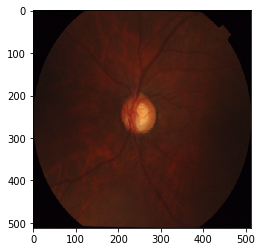

(50, 512, 512, 3)


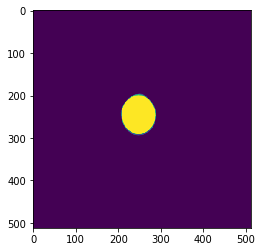

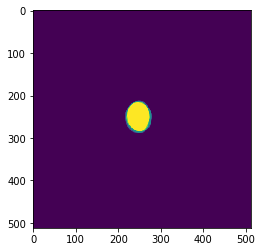

In [9]:
plt.imshow(img_train[0])
plt.show()
print(img_train.shape)
plt.imshow(np.squeeze(disc_train[0]))
plt.show()
plt.imshow(np.squeeze(cup_train[0]))
plt.show()

In [10]:
img_train, cup_train, disc_train, disc_locations

(<HDF5 dataset "images": shape (50, 512, 512, 3), type "|u1">,
 <HDF5 dataset "cup": shape (50, 512, 512, 1), type "|u1">,
 <HDF5 dataset "disc": shape (50, 512, 512, 1), type "|u1">,
 <HDF5 dataset "disc_locations": shape (50, 4), type "<i8">)

#### Generator of augmented data:

Testing the data generator and generator for augmented data:

In [11]:
gen = data_generator(img_train, cup_train, disc_locations, 128, 'train', batch_size=1)
batch = next(gen)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


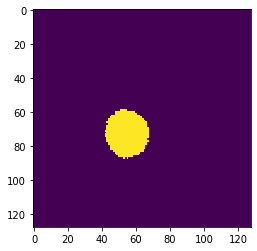

In [12]:
plt.imshow(np.squeeze(batch[1][0]))

In [13]:
arch_name = "OD Cup, U-Net light on DRISHTI-GS 512 px cropped to OD 128 px fold 0, SGD, log_dice loss"
weights_folder = os.path.join(os.path.dirname(os.getcwd()), 'models_weights',
                              '{}'.format(arch_name))

In [14]:
def folder(folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    return folder_name

In [15]:
img_test = h5f['DRISHTI-GS-test/512 px/images']
cup_test = h5f['DRISHTI-GS-test/512 px/cup']
disc_test = h5f['DRISHTI-GS-test/512 px/disc']
disc_locations_test = h5f['DRISHTI-GS-test/512 px/disc_locations']

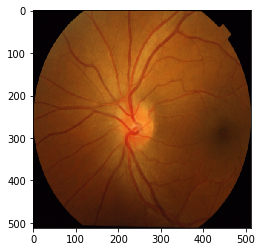

51


In [16]:
plt.imshow(img_test[50])
plt.show()
print(len(img_test))

In [17]:
X_valid, Y_valid = next(data_generator(img_test, cup_test, disc_locations_test, train_or_test='test', batch_size=100, stationary=True))

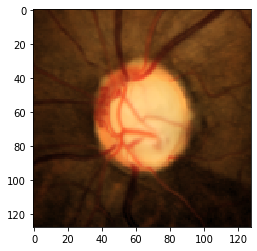

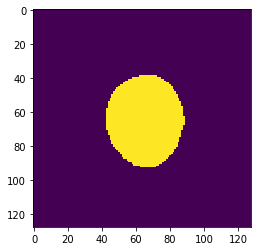

In [18]:
len(X_valid)

plt.imshow(X_valid[9])
plt.show()

plt.imshow(np.squeeze(Y_valid[9]))
plt.show()

### Training

If a pretrained model needs to be used, first run "Loading model" section below and then go the "Comprehensive visual check", skipping this section.

In [20]:
history = model.fit_generator(data_generator(img_train, cup_train, disc_locations, train_or_test='train', batch_size=1), 
                              steps_per_epoch=99,
                              max_queue_size=1,                                                
                              epochs=700, verbose=1,                              
                              callbacks=[CSVLogger(os.path.join(folder(weights_folder), 'training_log_cup_color.csv')),
                                         ModelCheckpoint(os.path.join(folder(weights_folder),
                                               'last_checkpoint_cup_color.hdf5'),
                                               monitor='val_loss', mode='min', save_best_only=True, 
                                               save_weights_only=False, verbose=0)])

Epoch 1/1
99/99 [==============================] - 26s 262ms/step - loss: 1.4760 - mean_IOU_gpu: 0.0084 - dice_metric: 0.0164


C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


### Visual check

image #0
(128, 128)


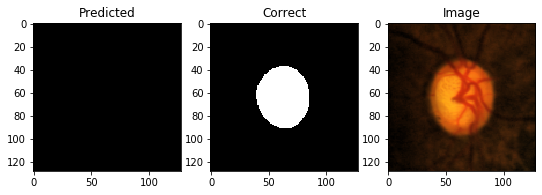

(128, 128)
IOU: 0.0
Dice: 0.0
image #1
(128, 128)


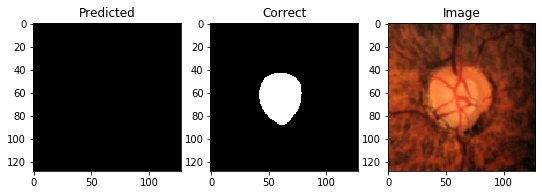

(128, 128)
IOU: 0.0
Dice: 0.0
image #2
(128, 128)


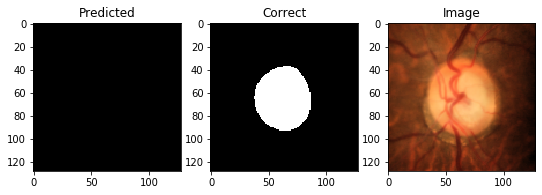

(128, 128)
IOU: 0.0
Dice: 0.0
image #3
(128, 128)


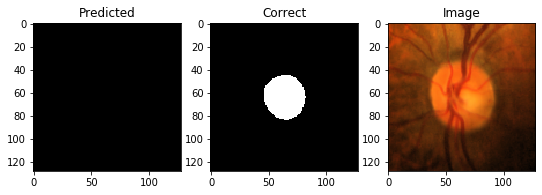

(128, 128)
IOU: 0.0
Dice: 0.0
image #4
(128, 128)


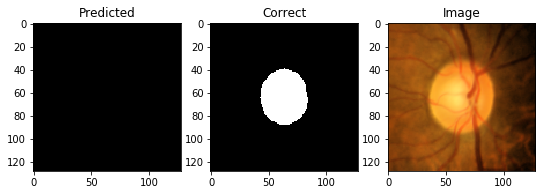

(128, 128)
IOU: 0.0
Dice: 0.0
image #5
(128, 128)


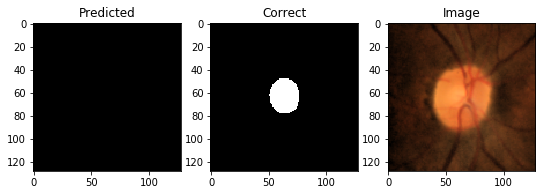

(128, 128)
IOU: 0.0
Dice: 0.0
image #6
(128, 128)


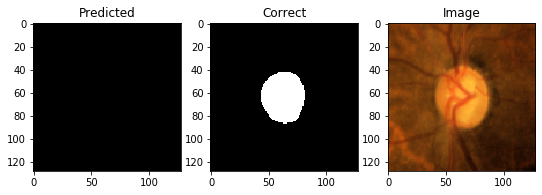

(128, 128)
IOU: 0.0
Dice: 0.0
image #7
(128, 128)


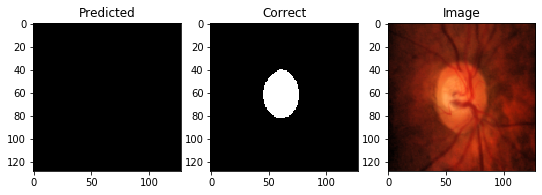

(128, 128)
IOU: 0.0
Dice: 0.0
image #8
(128, 128)


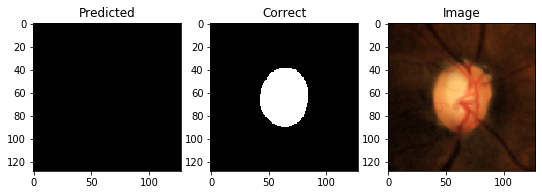

(128, 128)
IOU: 0.0
Dice: 0.0
image #9
(128, 128)


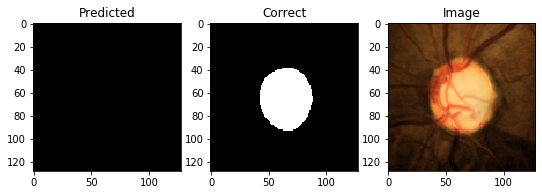

(128, 128)
IOU: 0.0
Dice: 0.0
image #10
(128, 128)


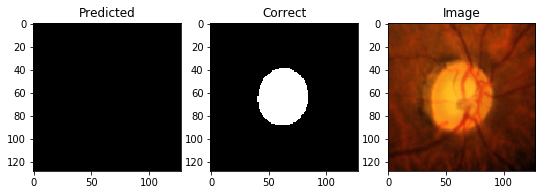

(128, 128)
IOU: 0.0
Dice: 0.0
image #11
(128, 128)


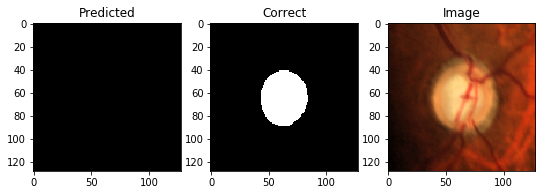

(128, 128)
IOU: 0.0
Dice: 0.0
image #12
(128, 128)


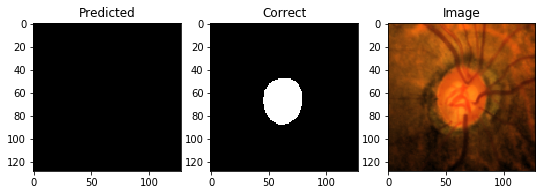

(128, 128)
IOU: 0.0
Dice: 0.0
image #13
(128, 128)


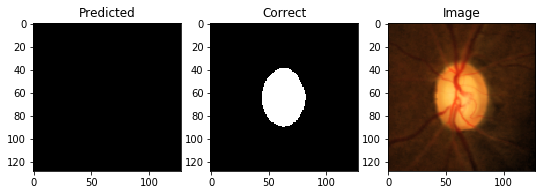

(128, 128)
IOU: 0.0
Dice: 0.0
image #14
(128, 128)


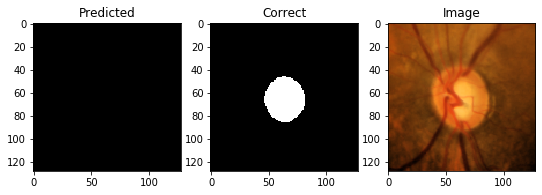

(128, 128)
IOU: 0.0
Dice: 0.0
image #15
(128, 128)


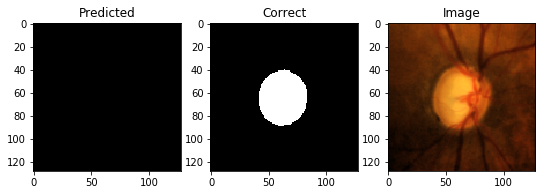

(128, 128)
IOU: 0.0
Dice: 0.0
image #16
(128, 128)


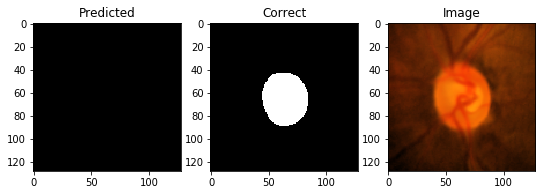

(128, 128)
IOU: 0.0
Dice: 0.0
image #17
(128, 128)


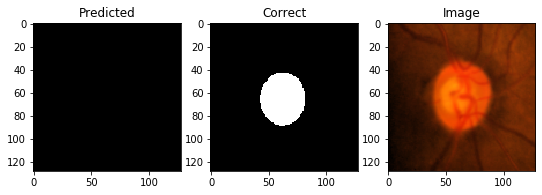

(128, 128)
IOU: 0.0
Dice: 0.0
image #18
(128, 128)


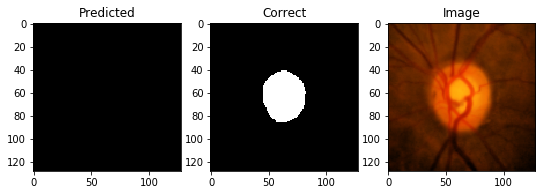

(128, 128)
IOU: 0.0
Dice: 0.0
image #19
(128, 128)


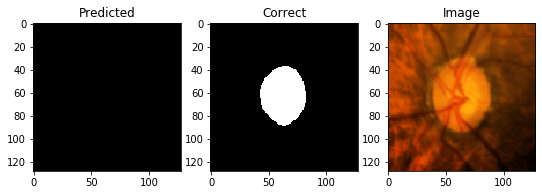

(128, 128)
IOU: 0.0
Dice: 0.0
image #20
(128, 128)


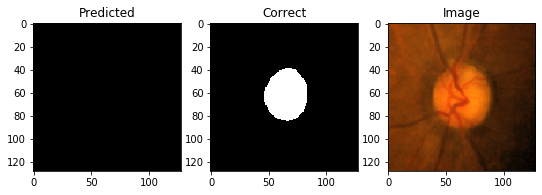

(128, 128)
IOU: 0.0
Dice: 0.0
image #21
(128, 128)


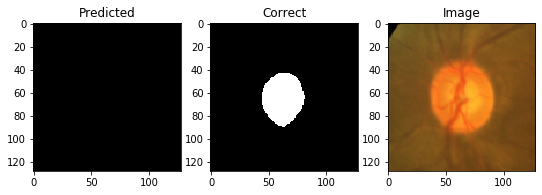

(128, 128)
IOU: 0.0
Dice: 0.0
image #22
(128, 128)


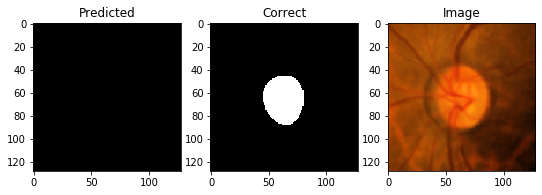

(128, 128)
IOU: 0.0
Dice: 0.0
image #23
(128, 128)


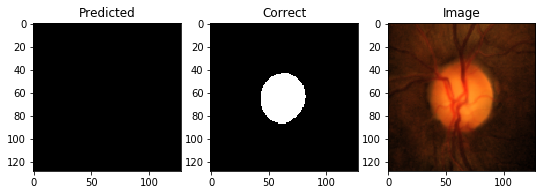

(128, 128)
IOU: 0.0
Dice: 0.0
image #24
(128, 128)


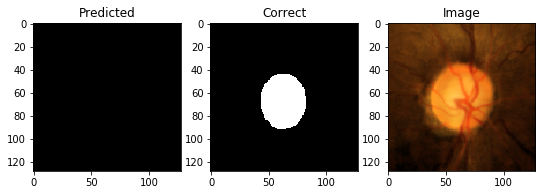

(128, 128)
IOU: 0.0
Dice: 0.0
image #25
(128, 128)


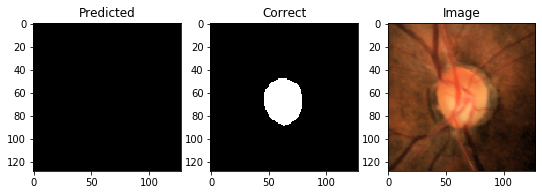

(128, 128)
IOU: 0.0
Dice: 0.0
image #26
(128, 128)


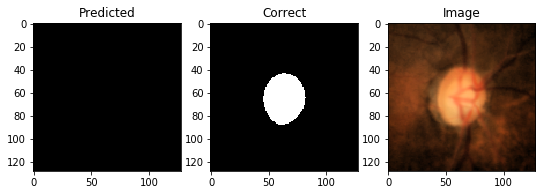

(128, 128)
IOU: 0.0
Dice: 0.0
image #27
(128, 128)


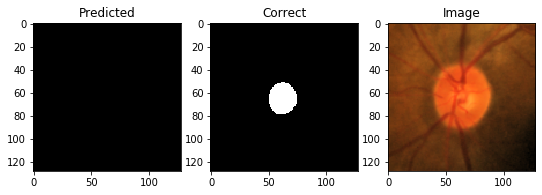

(128, 128)
IOU: 0.0
Dice: 0.0
image #28
(128, 128)


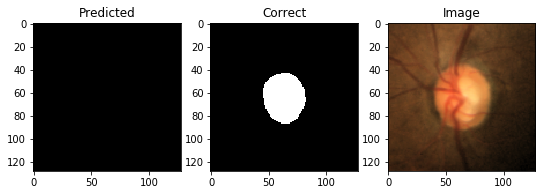

(128, 128)
IOU: 0.0
Dice: 0.0
image #29
(128, 128)


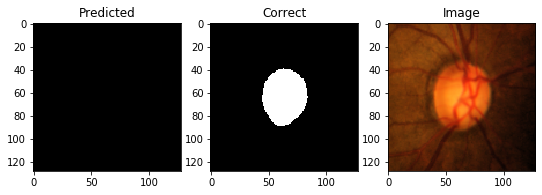

(128, 128)
IOU: 0.0
Dice: 0.0
image #30
(128, 128)


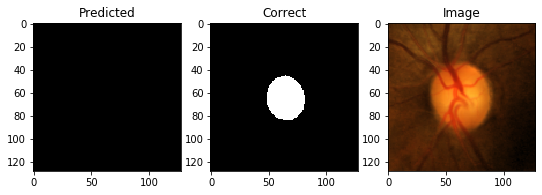

(128, 128)
IOU: 0.0
Dice: 0.0
image #31
(128, 128)


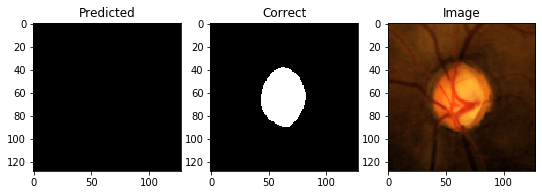

(128, 128)
IOU: 0.0
Dice: 0.0
image #32
(128, 128)


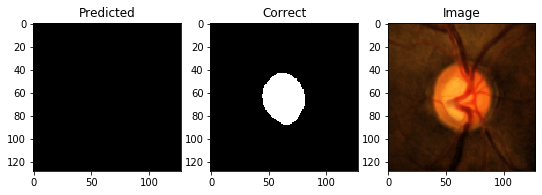

(128, 128)
IOU: 0.0
Dice: 0.0
image #33
(128, 128)


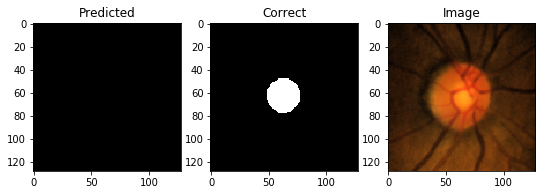

(128, 128)
IOU: 0.0
Dice: 0.0
image #34
(128, 128)


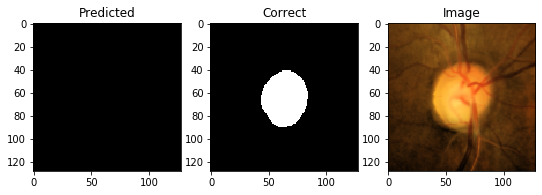

(128, 128)
IOU: 0.0
Dice: 0.0
image #35
(128, 128)


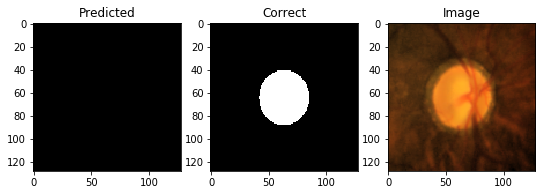

(128, 128)
IOU: 0.0
Dice: 0.0
image #36
(128, 128)


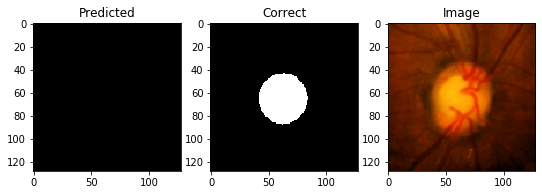

(128, 128)
IOU: 0.0
Dice: 0.0
image #37
(128, 128)


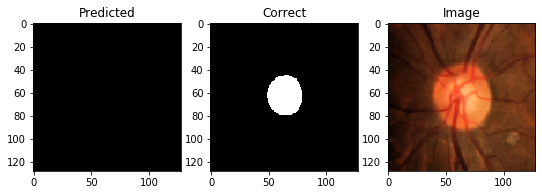

(128, 128)
IOU: 0.0
Dice: 0.0
image #38
(128, 128)


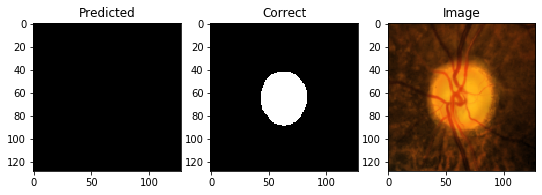

(128, 128)
IOU: 0.0
Dice: 0.0
image #39
(128, 128)


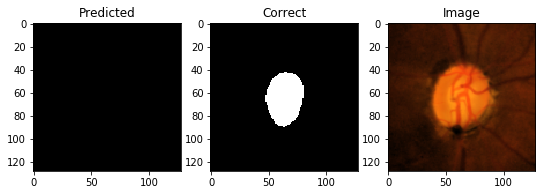

(128, 128)
IOU: 0.0
Dice: 0.0
image #40
(128, 128)


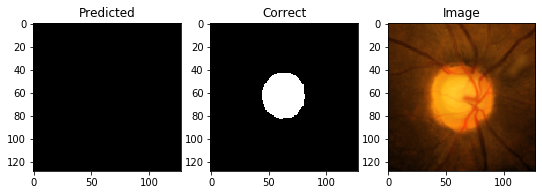

(128, 128)
IOU: 0.0
Dice: 0.0
image #41
(128, 128)


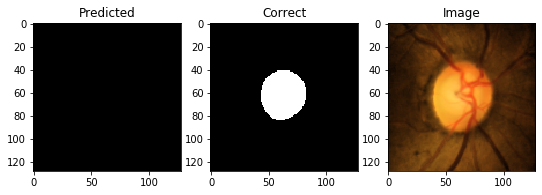

(128, 128)
IOU: 0.0
Dice: 0.0
image #42
(128, 128)


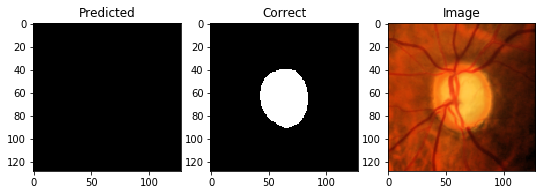

(128, 128)
IOU: 0.0
Dice: 0.0
image #43
(128, 128)


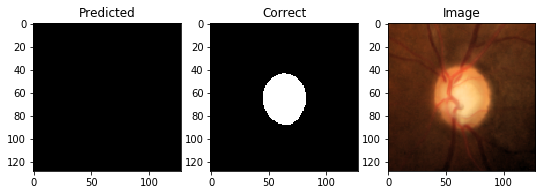

(128, 128)
IOU: 0.0
Dice: 0.0
image #44
(128, 128)


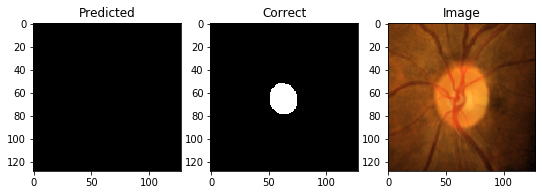

(128, 128)
IOU: 0.0
Dice: 0.0
image #45
(128, 128)


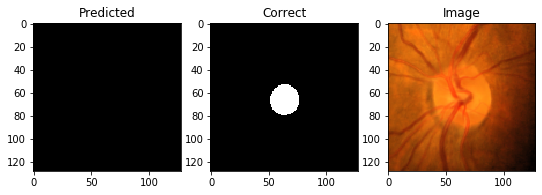

(128, 128)
IOU: 0.0
Dice: 0.0
image #46
(128, 128)


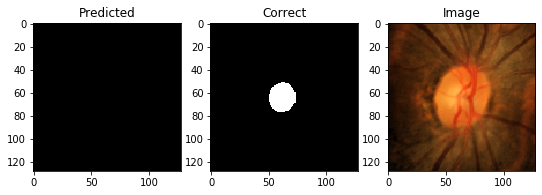

(128, 128)
IOU: 0.0
Dice: 0.0
image #47
(128, 128)


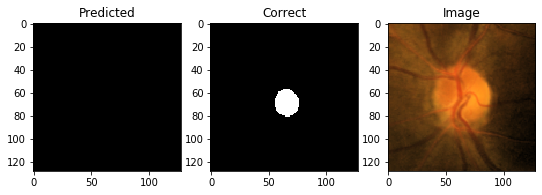

(128, 128)
IOU: 0.0
Dice: 0.0
image #48
(128, 128)


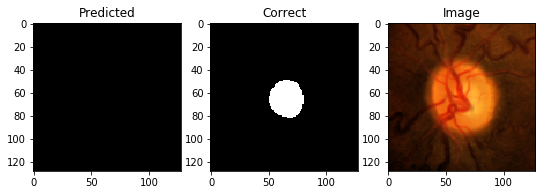

(128, 128)
IOU: 0.0
Dice: 0.0
image #49
(128, 128)


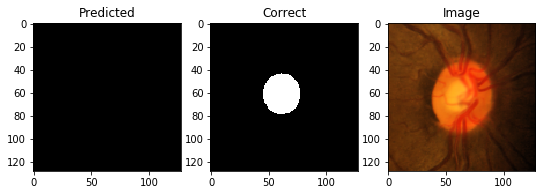

(128, 128)
IOU: 0.0
Dice: 0.0


In [41]:
pred_iou, pred_dice = [], []
pred_cup = []

for i, img_no in enumerate(test_idx):
    print('image #{}'.format(img_no))
    img = img_test[img_no]
    batch_X = X_valid[i:i + 1]
    batch_y = Y_valid[i:i + 1]

    pred = (model.predict(batch_X)[0] > 0.5).astype(np.float64)
    pred = pred.reshape(128,128,)
    pred_cup.append(pred)
    corr = (batch_y)[0, ..., 0]
            
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(pred, cmap=plt.cm.Greys_r)
    ax.set_title('Predicted')
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(corr, cmap=plt.cm.Greys_r)
    ax.set_title('Correct')
    ax = fig.add_subplot(1, 3, 3)
    ax.imshow((batch_X)[0])
    ax.set_title('Image')
    plt.show()
        
    cur_iou = K.eval(mean_IOU_gpu(pred[None, None, ...], corr[None, None, ...]))
    cur_dice = K.eval(dice(pred[None, None, ...], corr[None, None, ...]))
    print('IOU: {}\nDice: {}'.format(cur_iou, cur_dice))
    pred_iou.append(cur_iou)
    pred_dice.append(cur_dice)

Acquiring scores for the validation set:

In [ ]:
print(np.mean(pred_iou))
print(np.mean(pred_dice))

### Loading model

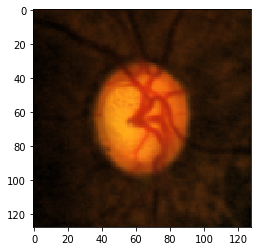

In [35]:
X_valid, Z_valid = next(data_generator(img_test, disc_test, disc_locations_test, train_or_test='test', batch_size=100, stationary=True))

In [ ]:
history = model.fit_generator(data_generator(img_train, disc_train, disc_locations, train_or_test='train', batch_size=1), 
                              steps_per_epoch=99,
                              max_queue_size=1,                                            
                              epochs=700, verbose=1,                              
                              callbacks=[CSVLogger(os.path.join(folder(weights_folder), 'training_log_disc_color.csv')),
                                         ModelCheckpoint(os.path.join(folder(weights_folder),
                                               'last_checkpoint_disc_color.hdf5'),
                                               monitor='val_loss', mode='min', save_best_only=True, 
                                               save_weights_only=False, verbose=0)])

Epoch 1/500
99/99 [==============================] - 54s 543ms/step - loss: 0.1415 - mean_IOU_gpu: 0.7631 - dice_metric: 0.8547
Epoch 2/500
99/99 [==============================] - 54s 550ms/step - loss: 0.0856 - mean_IOU_gpu: 0.8255 - dice_metric: 0.8998
Epoch 3/500
99/99 [==============================] - 63s 638ms/step - loss: 0.0574 - mean_IOU_gpu: 0.8665 - dice_metric: 0.9271
Epoch 4/500
99/99 [==============================] - 64s 646ms/step - loss: 0.0579 - mean_IOU_gpu: 0.8655 - dice_metric: 0.9263
Epoch 5/500
99/99 [==============================] - 64s 650ms/step - loss: 0.0538 - mean_IOU_gpu: 0.8789 - dice_metric: 0.9334
Epoch 6/500
99/99 [==============================] - 65s 659ms/step - loss: 0.0474 - mean_IOU_gpu: 0.8858 - dice_metric: 0.9389
Epoch 7/500
99/99 [==============================] - 67s 673ms/step - loss: 0.0510 - mean_IOU_gpu: 0.8806 - dice_metric: 0.9352
Epoch 8/500
99/99 [==============================] - 66s 671ms/step - loss: 0.0484 - mean_IOU_gpu: 0.884

99/99 [==============================] - 147s 1s/step - loss: 0.0356 - mean_IOU_gpu: 0.9113 - dice_metric: 0.9533
Epoch 66/500
99/99 [==============================] - 146s 1s/step - loss: 0.0342 - mean_IOU_gpu: 0.9146 - dice_metric: 0.9551
Epoch 67/500
99/99 [==============================] - 147s 1s/step - loss: 0.0348 - mean_IOU_gpu: 0.9132 - dice_metric: 0.9544
Epoch 68/500
99/99 [==============================] - 146s 1s/step - loss: 0.0300 - mean_IOU_gpu: 0.9242 - dice_metric: 0.9604
Epoch 69/500
99/99 [==============================] - 146s 1s/step - loss: 0.0358 - mean_IOU_gpu: 0.9107 - dice_metric: 0.9529
Epoch 70/500
99/99 [==============================] - 146s 1s/step - loss: 0.0336 - mean_IOU_gpu: 0.9167 - dice_metric: 0.9563
Epoch 71/500
99/99 [==============================] - 146s 1s/step - loss: 0.0339 - mean_IOU_gpu: 0.9160 - dice_metric: 0.9558
Epoch 72/500
99/99 [==============================] - 146s 1s/step - loss: 0.0356 - mean_IOU_gpu: 0.9123 - dice_metric: 0.95

In [ ]:
pred_iou, pred_dice = [], []
pred_disc = []

for i, img_no in enumerate(test_idx):
    print('image #{}'.format(img_no))
    img = img_train[img_no]
    batch_X = X_valid[i:i + 1]
    batch_z = Z_valid[i:i + 1]
    
    pred = (model.predict(batch_X)[0] > 0.5).astype(np.float64)
    pred = pred.reshape(128,128,)
    pred_disc.append(pred)
    corr = (batch_z)[0, ..., 0]
            
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(pred, cmap=plt.cm.Greys_r)
    ax.set_title('Predicted')
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(corr, cmap=plt.cm.Greys_r)
    ax.set_title('Correct')
    ax = fig.add_subplot(1, 3, 3)
    ax.imshow((batch_X)[0])
    ax.set_title('Image')
    plt.show()
        
    cur_iou = K.eval(mean_IOU_gpu(pred[None, None, ...], corr[None, None, ...]))
    cur_dice = K.eval(dice(pred[None, None, ...], corr[None, None, ...]))
    print('IOU: {}\nDice: {}'.format(cur_iou, cur_dice))
    pred_iou.append(cur_iou)
    pred_dice.append(cur_dice)

In [ ]:
print(np.mean(pred_iou))
print(np.mean(pred_dice))

In [ ]:
cdrs = []
for i, img_no in enumerate(test_idx):
    cup = pred_cup[i]
    disc = pred_disc[i]
        
    c = cv2.Canny(cup.astype(np.uint8), 1,1)
    d = cv2.Canny(disc.astype(np.uint8), 1,1)
    
    el_c, diam_c = ellipseFitting(c)
    el_d, diam_d = ellipseFitting(d)
        
    if len(diam_d) > 0 and len(diam_c) > 0:
        cdr = diam_c[0][1]/diam_d[0][1]
        cdrs.append(cdr)
        print('image #{} - cdr = {}'.format(img_no, cdr))
